In [1]:
# %matplotlib widget
import numpy as np 
import matplotlib.pyplot as plt 

import jax
import jax.numpy as jnp 
from jax import jit, random,vmap
from mppi_proj_obs_avoidance import pi_mppi 
from mppi_proj_obs_avoidance_learned import proj_cem_fwv as proj_cem_fwv_learned
import time

In [2]:
import torch
from mlp_obst_avoidance import MLP, mlp_projection_filter
from bernstein_torch import bernstein_coeff_order10_new

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
# Generating P matrix
t_fin = 20.0
num = 100
tot_time = torch.linspace(0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)
P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
P_diag = torch.block_diag(P, P)
Pdot_diag = torch.block_diag(Pdot, Pdot)

Pddot_diag = torch.block_diag(Pddot, Pddot)
nvar = P.size(dim = 1)

In [4]:
dist = 150
num_obs = 100
num_case = 250

### Upload cases (obstacles and goal points)

goal_location = np.load('./data/goal_loc_data_{}_{}_{}.npy'.format(dist,num_obs,num_case)) # (x,y,z)

obs_x_batch = np.load('./data/obs_x_data_{}_{}_{}.npy'.format(dist,num_obs,num_case))
obs_y_batch = np.load('./data/obs_y_data_{}_{}_{}.npy'.format(dist,num_obs,num_case))
obs_z_batch = np.load('./data/obs_z_data_{}_{}_{}.npy'.format(dist,num_obs,num_case))
obs_r_batch = np.load('./data/obs_r_data_{}_{}_{}.npy'.format(dist,num_obs,num_case))

# Number of cases

# num_case = goal_location.shape[0]
num_case = 1


In [5]:
data_train = np.load("./data/data_out_obs_150_100_250.npz")
inp_mean = data_train['mean']
inp_std = data_train['std'] 

In [6]:
num_batch = 1000
# Constraints 

v_min = 12.0
v_max = 20.0

vdot_max = 3
vdot_min = -3

vddot_max = 3.0
vddot_min = -3.0

pitch_max = 0.2
pitch_min = -0.2

pitchdot_max = 0.25
pitchdot_min = -0.25

pitchddot_max = 0.15    
pitchddot_min = -0.15

roll_max = 0.25
roll_min = -0.25

rolldot_max = 0.25
rolldot_min = -0.25

rollddot_max = 0.15
rollddot_min = -0.15


In [7]:
# Initial Conditions/obstacles/goal

# Initial states 
x_init = 0
y_init = 0
z_init = 0
psi_init = -jnp.pi/2

# Initial controls
v_init = 16
pitch_init = 0
roll_init = 0

# Dot init 
vdot_init = 0.
pitchdot_init = 0.
rolldot_init = 0.

In [8]:
# Initialization
mppi_learned = proj_cem_fwv_learned(v_max, v_min, vdot_max, vdot_min, vddot_max,vddot_min,
                    pitch_max,pitch_min, pitchdot_max, pitchdot_min, pitchddot_max, pitchddot_min,
                      roll_max, roll_min, rolldot_max, rolldot_min, rollddot_max, rollddot_min, num_batch, t_fin, num)

mppi_proj = pi_mppi(v_max, v_min, vdot_max, vdot_min, vddot_max,vddot_min,
                    pitch_max,pitch_min, pitchdot_max, pitchdot_min, pitchddot_max, pitchddot_min,
                      roll_max, roll_min, rolldot_max, rolldot_min, rollddot_max, rollddot_min)

In [9]:
# Number of mpc iterations to be run
timesteps = 1000

# Storing Values - Projection
states_proj_global = np.zeros((num_case,timesteps,4)) # storing x,y,z,psi 
states_train = np.zeros((num_case,timesteps,6))
controls_proj = np.zeros((num_case,timesteps,3)) # storing velocity, pitch, roll
controls_dot_proj = np.zeros((num_case,timesteps,3)) 
controls_ddot_proj = np.zeros((num_case,timesteps,3))

obs_dist_proj = np.zeros((num_case,timesteps,num_obs))

mean_proj_values = np.zeros((num_case,timesteps,33))

states_learned_global = np.zeros((num_case,timesteps,4)) # storing x,y,z,psi 
states_train_learned = np.zeros((num_case,timesteps,6))
controls_learned = np.zeros((num_case,timesteps,3)) # storing velocity, pitch, roll
controls_dot_learned = np.zeros((num_case,timesteps,3)) 
controls_ddot_learned = np.zeros((num_case,timesteps,3))

obs_dist_learned = np.zeros((num_case,timesteps,num_obs))

mean_learned_values = np.zeros((num_case,timesteps,33))
# raw_sample_values = np.zeros((num_case,timesteps,num_batch,33))
# proj_sample_values = np.zeros((num_case,timesteps,num_batch,33))

# Iterations
iter_left = num_case



In [10]:
cov_v_control = 40*jnp.identity(nvar)
cov_angle_control = jnp.identity(nvar*2)*6
cov_control_init = jax.scipy.linalg.block_diag(cov_v_control, cov_angle_control)

In [11]:
P = P.to(device) 
Pdot = Pdot.to(device)
P_diag = P_diag.to(device)
Pdot_diag = Pdot_diag.to(device)

Pddot_diag = Pddot_diag.to(device)

num_dot = num 
num_ddot = num_dot 
num_constraint = 2*num+2*num_dot+2*num_ddot

# CVAE input
enc_inp_dim = 3*nvar+6
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 6*nvar#+3*num_constraint
print(mlp_out_dim)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)
model = mlp_projection_filter(P, Pdot, Pddot, mlp, num_batch, inp_mean, inp_std, t_fin).to(device)

# model.load_state_dict(torch.load("./training_scripts/weights/mlp_learned_proj_obs_150_100_250.pth", map_location=torch.device('cpu')))
model.load_state_dict(torch.load("./data/mlp_learned_proj_obs_150_100_250.pth"))
model.eval()

66


/tmp/ipykernel_47988/3357066848.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./data/mlp_learned_proj_obs_150_100_250.pth"))


mlp_projection_filter(
  (mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=39, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=256, out_features=66, bias=True)
    )
  )
  (rcl_loss): MSELoss()
)

In [12]:
for k in range(num_case):

  # Goal Location
  x_goal = goal_location[k,0]
  y_goal = goal_location[k,1]
  z_goal = goal_location[k,2]

  # Obstacles 
  x_obs = obs_x_batch[k,:]
  y_obs = obs_y_batch[k,:]
  z_obs = obs_z_batch[k,:]
  r_obs = obs_r_batch[k,:]


  # Init
  x_init_learned_global = x_init
  y_init_learned_global = y_init
  z_init_learned_global = z_init

  x_goal_learned_ego = x_goal
  y_goal_learned_ego = y_goal
  z_goal_learned_ego = z_goal

  x_obs_learned_ego = x_obs
  y_obs_learned_ego = y_obs
  z_obs_learned_ego = z_obs

  psi_learned_init = psi_init
  v_learned_init = v_init
  pitch_learned_init = pitch_init
  roll_learned_init = roll_init

  # Init Proj
  x_init_proj_global = x_init
  y_init_proj_global = y_init
  z_init_proj_global = z_init

  x_goal_proj_ego = x_goal
  y_goal_proj_ego = y_goal
  z_goal_proj_ego = z_goal

  x_obs_proj_ego = x_obs
  y_obs_proj_ego = y_obs
  z_obs_proj_ego = z_obs

  psi_proj_init = psi_init
  v_proj_init = v_init
  pitch_proj_init = pitch_init
  roll_proj_init = roll_init

  # Dot init 
  vdot_learned_init = vdot_init
  pitchdot_learned_init = pitchdot_init
  rolldot_learned_init = rolldot_init 

  # Dot init - Projection MPPI
  vdot_proj_init = vdot_init
  pitchdot_proj_init = pitchdot_init
  rolldot_proj_init = rolldot_init 

  # Key generation
  key_learned = random.PRNGKey(0)
  key_proj = random.PRNGKey(0)
  
  # Mean - Projection MPPI
  mean_v_control = jnp.zeros(nvar) 
  mean_pitch_control = jnp.zeros(nvar)
  mean_roll_control = jnp.zeros(nvar) 
  mean_proj = jnp.hstack(( mean_v_control, mean_pitch_control, mean_roll_control  ))
  mean_learned = jnp.hstack(( mean_v_control, mean_pitch_control, mean_roll_control  ))



  start = time.time()
  for i in range(timesteps):

    #### Projected MPPI
    states_jax_learned = jnp.array([x_init_learned_global,y_init_learned_global,z_init_learned_global,psi_learned_init])
    states_learned_global[k,i,:] = np.asarray(states_jax_learned)	

		# MPPI
    c_v_samples, c_pitch_samples, c_roll_samples, key_learned = mppi_learned.compute_control_samples(key_learned, mean_learned, cov_control_init)

    # print(c_v_samples)
    # print(np.dot(P.detach().cpu().numpy(), c_v_samples.T).T)

    # network prediction ##
    c_samples_input_numpy = np.hstack((np.asarray(c_v_samples),np.asarray(c_pitch_samples),np.asarray(c_roll_samples))) 
    init_state_temp_numpy = np.vstack(( v_learned_init, vdot_learned_init, pitch_learned_init, pitchdot_learned_init, roll_learned_init, rolldot_learned_init   )).T
    init_state_numpy = np.tile(init_state_temp_numpy,(num_batch,1))
    inp = np.hstack(( init_state_numpy, c_samples_input_numpy  ))
    
    # Normalize input
    inp_norm = (inp - inp_mean) / inp_std

    # solver_time = time.time()
    # nn_time = time.time()
    
    with torch.no_grad():
      neural_output_batch = mlp(torch.tensor(inp_norm).float().to(device))
    
    # print("nn_time = ",time.time()-nn_time)

    lamda_samples = neural_output_batch[:, 0 : 3*nvar  ]
    c_samples = neural_output_batch[:, 3*nvar : 6*nvar]

    lamda_v = lamda_samples[:, 0 : nvar ]
    lamda_pitch = lamda_samples[:, nvar : 2*nvar ]
    lamda_roll = lamda_samples[:, 2*nvar : 3*nvar ]

    c_v_samples_temp = c_samples[:, 0 : nvar ]
    c_pitch_samples_temp = c_samples[:, nvar : 2*nvar ]
    c_roll_samples_temp = c_samples[:, 2*nvar : 3*nvar ]

    lamda_v_numpy         = lamda_v.detach().cpu().numpy()        
    lamda_pitch_numpy     = lamda_pitch.detach().cpu().numpy()    
    lamda_roll_numpy      = lamda_roll.detach().cpu().numpy()     
    c_v_samples_numpy     = c_v_samples_temp.detach().cpu().numpy()    
    c_pitch_samples_numpy = c_pitch_samples_temp.detach().cpu().numpy()
    c_roll_samples_numpy  = c_roll_samples_temp.detach().cpu().numpy() 

    lamda_v_init         = jnp.asarray(lamda_v_numpy        )
    lamda_pitch_init     = jnp.asarray(lamda_pitch_numpy    )
    lamda_roll_init      = jnp.asarray(lamda_roll_numpy     )
    c_v_samples_nn     = jnp.asarray(c_v_samples_numpy    )
    c_pitch_samples_nn = jnp.asarray(c_pitch_samples_numpy)
    c_roll_samples_nn  = jnp.asarray(c_roll_samples_numpy )

    solver_time = time.time()

    mean_learned,init_states_upd_learned,init_controls_upd_learned,controls_dot_l,controls_ddot_l = mppi_learned.compute_cem(v_learned_init,
                                                                                              vdot_learned_init, pitch_learned_init,
                                                                                              pitchdot_learned_init, roll_learned_init, rolldot_learned_init,
                                                                                                psi_learned_init,
                                                                                                  x_init, y_init, z_init,
                                                                                                  x_goal_learned_ego, y_goal_learned_ego, z_goal_learned_ego,
                                                                                                  x_obs_learned_ego,y_obs_learned_ego,z_obs_learned_ego,r_obs,
                                                                                                  lamda_v_init,lamda_pitch_init,lamda_roll_init,
                                                                                                  c_v_samples_nn,c_pitch_samples_nn,c_roll_samples_nn,
                                                                                                  c_v_samples,c_pitch_samples,c_roll_samples)
                                                                        
    #print("solver time =",time.time()-solver_time)
    
    # Global location

    x_init_learned_global = x_init_learned_global + init_states_upd_learned[0]
    y_init_learned_global = y_init_learned_global + init_states_upd_learned[1]
    z_init_learned_global = z_init_learned_global + init_states_upd_learned[2]

    # Goal/obs to ego 

    x_goal_learned_ego = x_goal_learned_ego - init_states_upd_learned[0]
    y_goal_learned_ego = y_goal_learned_ego - init_states_upd_learned[1]
    z_goal_learned_ego = z_goal_learned_ego - init_states_upd_learned[2]

    x_obs_learned_ego = x_obs_learned_ego - init_states_upd_learned[0]
    y_obs_learned_ego = y_obs_learned_ego - init_states_upd_learned[1]
    z_obs_learned_ego = z_obs_learned_ego - init_states_upd_learned[2]

    # Update
    psi_learned_init = init_states_upd_learned[3]

    v_learned_init, pitch_learned_init, roll_learned_init = init_controls_upd_learned[0],init_controls_upd_learned[1],init_controls_upd_learned[2]
    # print(controls_dot)
    vdot_learned_init, pitchdot_learned_init, rolldot_learned_init = controls_dot_l[0],controls_dot_l[1],controls_dot_l[2]

    controls_jax_learned = jnp.array([v_learned_init, pitch_learned_init, roll_learned_init ])

    # Storing controls,states
    # states_proj[k,i,:] = np.asarray(init_states_upd_proj)
    controls_learned[k,i,:] = np.asarray(controls_jax_learned)
    controls_dot_learned[k,i,:] = np.asarray(controls_dot_l)
    controls_ddot_learned[k,i,:] = np.asarray(controls_ddot_l)
    mean_learned_values[k,i,:] = np.asarray(mean_learned)
    # raw_sample_values[k,i,:,:] = np.asarray(raw_samples)
    # proj_sample_values[k,i,:,:] = np.asarray(proj_samples)
    states_train_learned[k,i,:] = np.array([v_learned_init,vdot_learned_init,pitch_learned_init,pitchdot_learned_init,roll_learned_init,rolldot_learned_init])
  
    obs_dist_learned[k,i,:] = np.asarray(jnp.sqrt((x_init_learned_global - x_obs)**2+(y_init_learned_global-y_obs)**2+(z_init_learned_global-z_obs)**2)-r_obs)

    #### Projected MPPI
    states_jax_proj = jnp.array([x_init_proj_global,y_init_proj_global,z_init_proj_global,psi_proj_init])
    states_proj_global[k,i,:] = np.asarray(states_jax_proj)

    mean_proj,key_proj,init_states_upd_proj,init_controls_upd_proj,controls_dot,controls_ddot= mppi_proj.pi_mppi_main(v_proj_init,
                                                                                              vdot_proj_init, pitch_proj_init,
                                                                                              pitchdot_proj_init, roll_proj_init, rolldot_proj_init,
                                                                                                psi_proj_init,
                                                                                                  x_init, y_init, z_init,
                                                                                                  x_goal_proj_ego, y_goal_proj_ego, z_goal_proj_ego,
                                                                                                    mean_proj,key_proj,
                                                                                                    x_obs_proj_ego,y_obs_proj_ego,z_obs_proj_ego,r_obs)
                                                                        
    # Global location

    x_init_proj_global = x_init_proj_global + init_states_upd_proj[0]
    y_init_proj_global = y_init_proj_global + init_states_upd_proj[1]
    z_init_proj_global = z_init_proj_global + init_states_upd_proj[2]

    # Goal/obs to ego 

    x_goal_proj_ego = x_goal_proj_ego - init_states_upd_proj[0]
    y_goal_proj_ego = y_goal_proj_ego - init_states_upd_proj[1]
    z_goal_proj_ego = z_goal_proj_ego - init_states_upd_proj[2]

    x_obs_proj_ego = x_obs_proj_ego - init_states_upd_proj[0]
    y_obs_proj_ego = y_obs_proj_ego - init_states_upd_proj[1]
    z_obs_proj_ego = z_obs_proj_ego - init_states_upd_proj[2]

    # Update
    psi_proj_init = init_states_upd_proj[3]

    v_proj_init, pitch_proj_init, roll_proj_init = init_controls_upd_proj[0],init_controls_upd_proj[1],init_controls_upd_proj[2]
    # print(controls_dot)
    vdot_proj_init, pitchdot_proj_init, rolldot_proj_init = controls_dot[0],controls_dot[1],controls_dot[2]

    controls_jax_proj = jnp.array([v_proj_init, pitch_proj_init, roll_proj_init ])

    # Storing controls,states
    # states_proj[k,i,:] = np.asarray(init_states_upd_proj)
    controls_proj[k,i,:] = np.asarray(controls_jax_proj)
    controls_dot_proj[k,i,:] = np.asarray(controls_dot)
    controls_ddot_proj[k,i,:] = np.asarray(controls_ddot)
    mean_proj_values[k,i,:] = np.asarray(mean_proj)
    # raw_sample_values[k,i,:,:] = np.asarray(raw_samples)
    # proj_sample_values[k,i,:,:] = np.asarray(proj_samples)
    states_train[k,i,:] = np.array([v_proj_init,vdot_proj_init,pitch_proj_init,pitchdot_proj_init,roll_proj_init,rolldot_proj_init])
  
    obs_dist_proj[k,i,:] = np.asarray(jnp.sqrt((x_init_proj_global - x_obs)**2+(y_init_proj_global-y_obs)**2+(z_init_proj_global-z_obs)**2)-r_obs)

  iter_left = iter_left - 1


  print('Cases left: ', iter_left,' Time taken: ',time.time()-start,'s.', 'Intersected obstacle: (Learned): ',np.any(obs_dist_learned[k]<=0,axis=(0,1)))
  print('Cases left: ', iter_left,' Time taken: ',time.time()-start,'s.','Intersected obstacle: (Proj): ',np.any(obs_dist_proj[k]<=0,axis=(0,1)))

fail_learned_cases = (np.any(obs_dist_learned<=0,axis = (2,1))).astype(int)

success_learned_overall = (num_case - np.sum(fail_learned_cases))/num_case * 100

print('Learned success % :',success_learned_overall,'%')

fail_proj_cases = (np.any(obs_dist_proj<=0,axis = (2,1))).astype(int)

success_proj_overall = (num_case - np.sum(fail_proj_cases))/num_case * 100

print('Projection success % :',success_proj_overall,'%')


Cases left:  0  Time taken:  47.3229866027832 s. Intersected obstacle: (Learned):  False
Cases left:  0  Time taken:  47.32328009605408 s. Intersected obstacle: (Proj):  False
Learned success % : 100.0 %
Projection success % : 100.0 %


In [13]:
print("base",fail_learned_cases)
print("proj",fail_proj_cases)

base [0]
proj [0]


In [14]:
case_num = 0

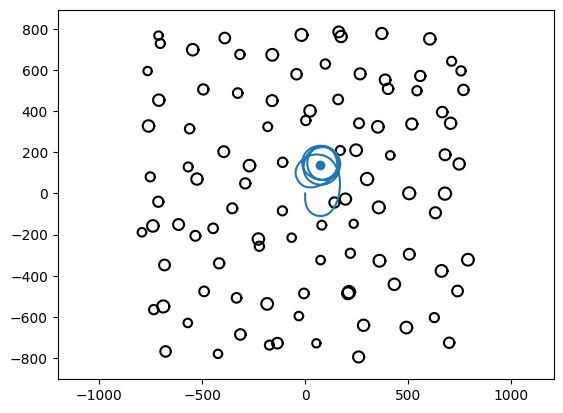

In [15]:
plt.figure()
x_obs = obs_x_batch[case_num]
y_obs = obs_y_batch[case_num]
r_obs = obs_r_batch[case_num]

x_goal = goal_location[case_num,0]
y_goal = goal_location[case_num,1]
for k in range(len(x_obs)):
    th = jnp.linspace(0, jnp.pi*2, 180)
    x_circ = x_obs[k]+r_obs[k]*jnp.cos(th)
    y_circ = y_obs[k]+r_obs[k]*jnp.sin(th)
    plt.plot(x_circ, y_circ, '-k')
plt.plot(states_learned_global[case_num,:,0],states_learned_global[case_num,:,1])
plt.scatter(x_goal,y_goal)
plt.axis('equal')
plt.show()

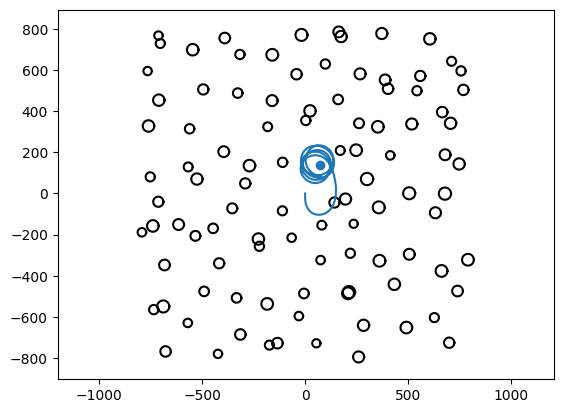

In [16]:
plt.figure()
x_obs = obs_x_batch[case_num]
y_obs = obs_y_batch[case_num]
r_obs = obs_r_batch[case_num]

x_goal = goal_location[case_num,0]
y_goal = goal_location[case_num,1]
for k in range(len(x_obs)):
    th = jnp.linspace(0, jnp.pi*2, 180)
    x_circ = x_obs[k]+r_obs[k]*jnp.cos(th)
    y_circ = y_obs[k]+r_obs[k]*jnp.sin(th)
    plt.plot(x_circ, y_circ, '-k')
plt.plot(states_proj_global[case_num,:,0],states_proj_global[case_num,:,1])
plt.scatter(x_goal,y_goal)
plt.axis('equal')
plt.show()

In [17]:
# plt.Figure()
# ax1 = plt.axes(projection='3d')
# theta = np.linspace(0, 2.*np.pi, 100)
# phi = np.linspace(0, np.pi, 100)
# for j in range(num_obs):
#     xp_obs = x_obs[j]+r_obs[j] * np.outer(np.cos(theta), np.sin(phi))
#     yp_obs = y_obs[j]+r_obs[j] * np.outer(np.sin(theta), np.sin(phi))
#     zp_obs = z_obs[j]+r_obs[j] * np.outer(np.ones(np.size(theta)), np.cos(phi))
#     ax1.plot_surface(xp_obs, yp_obs, zp_obs, color='r')

# ax1.plot3D(states_base_global[case_num,:,0],states_base_global[case_num,:,1],states_base_global[case_num,:,2])

# plt.show()

In [18]:
# print(obs_dist_base)

In [19]:
# %matplotlib widget
# fig = plt.figure(1)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(states_base_global[:,0],states_base_global[:,1],states_base_global[:,2],color='red')
# ax.plot(states_proj_global[:,0],states_proj_global[:,1],states_proj_global[:,2],color='blue')
# plt.scatter(x_goal,y_goal,z_goal)
# plt.show()

# plt.figure(2)
# plt.plot(states_base_global[:,0],states_base_global[:,1])
# plt.plot(states_proj_global[:,0],states_proj_global[:,1])

# for k in range(len(x_obs)):
#     th = jnp.linspace(0, jnp.pi*2, 180)
#     x_circ = x_obs[k]+r_obs[k]*jnp.cos(th)
#     y_circ = y_obs[k]+r_obs[k]*jnp.sin(th)
#     plt.plot(x_circ, y_circ, '-k')
# plt.scatter(x_goal,y_goal)
# plt.axis('equal')
# plt.show()

# plt.figure(13)
# plt.plot(obst_dist_base)
# plt.title('Obstacle avoidance - BASE')
# plt.show()

# plt.figure(14)
# plt.plot(obst_dist_proj)
# plt.title('Obstacle avoidance - PROJ')
# plt.show()


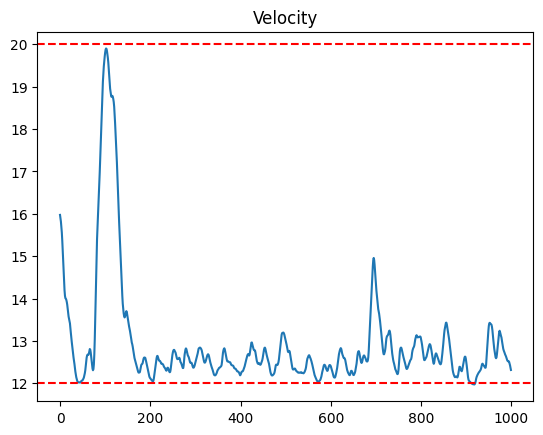

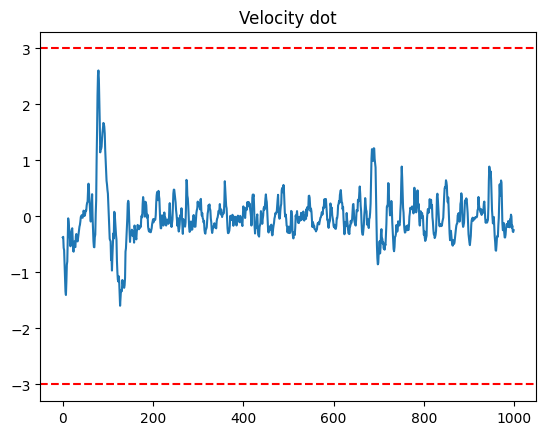

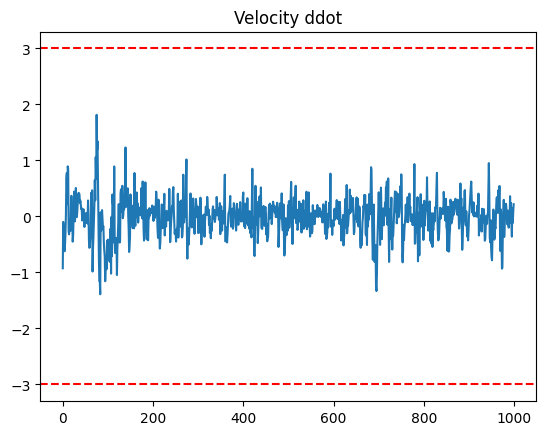

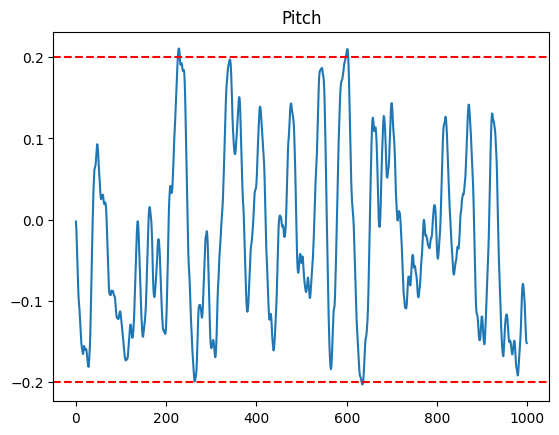

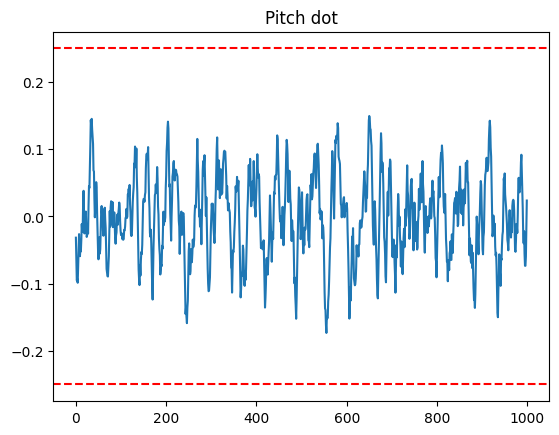

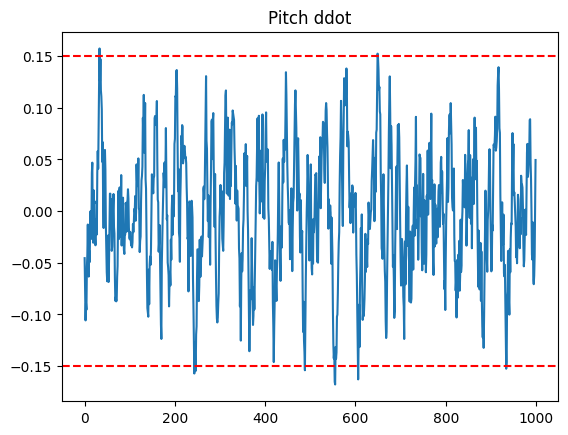

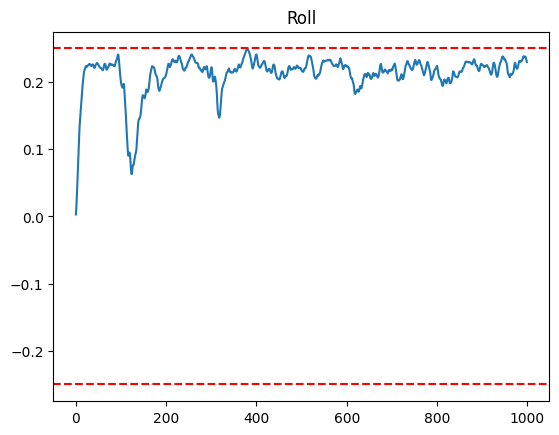

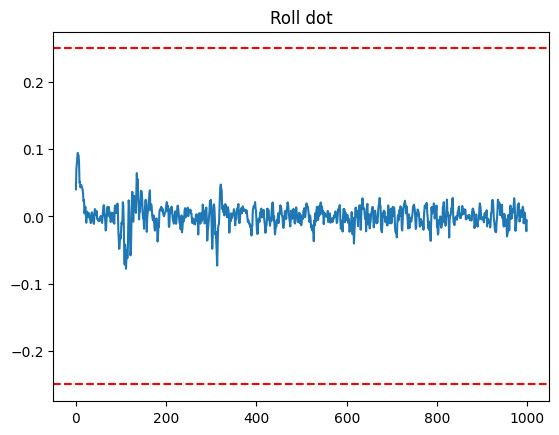

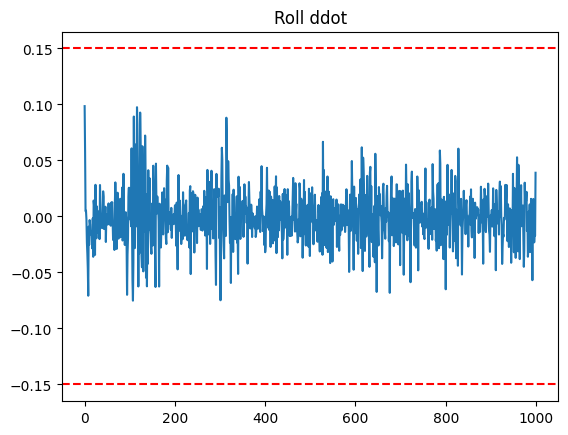

In [20]:
plt.figure()
plt.plot(controls_proj[:,:,0].T)
plt.axhline(y=v_max, color='red', linestyle='--')
plt.axhline(y=v_min, color='red', linestyle='--')
plt.title('Velocity')
plt.show()

plt.figure()
plt.plot(controls_dot_proj[:,:,0].T)
plt.axhline(y=vdot_max, color='red', linestyle='--')
plt.axhline(y=vdot_min, color='red', linestyle='--')
plt.title('Velocity dot')
plt.show()

plt.figure()
plt.plot(controls_ddot_proj[:,:,0].T)
plt.axhline(y=vddot_max, color='red', linestyle='--')
plt.axhline(y=vddot_min, color='red', linestyle='--')
plt.title('Velocity ddot')
plt.show()

plt.figure()
plt.plot(controls_proj[:,:,1].T)
plt.axhline(y=pitch_max, color='red', linestyle='--')
plt.axhline(y=pitch_min, color='red', linestyle='--')
plt.title('Pitch')
plt.show()

plt.figure()
plt.plot(controls_dot_proj[:,:,1].T)
plt.axhline(y=pitchdot_max, color='red', linestyle='--')
plt.axhline(y=pitchdot_min, color='red', linestyle='--')
plt.title('Pitch dot')
plt.show()

plt.figure()
plt.plot(controls_ddot_proj[:,:,1].T)
plt.axhline(y=pitchddot_max, color='red', linestyle='--')
plt.axhline(y=pitchddot_min, color='red', linestyle='--')
plt.title('Pitch ddot')
plt.show()  

plt.figure()
plt.plot(controls_proj[:,:,2].T)
plt.axhline(y=roll_max, color='red', linestyle='--')
plt.axhline(y=roll_min, color='red', linestyle='--')
plt.title('Roll')
plt.show()

plt.figure()
plt.plot(controls_dot_proj[:,:,2].T)
plt.axhline(y=rolldot_max, color='red', linestyle='--')
plt.axhline(y=rolldot_min, color='red', linestyle='--')
plt.title('Roll dot')
plt.show()

plt.figure()
plt.plot(controls_ddot_proj[:,:,2].T)
plt.axhline(y=rollddot_max, color='red', linestyle='--')
plt.axhline(y=rollddot_min, color='red', linestyle='--')
plt.title('Roll ddot')
plt.show()

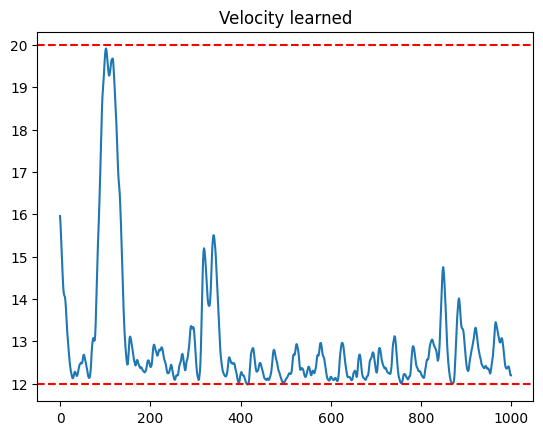

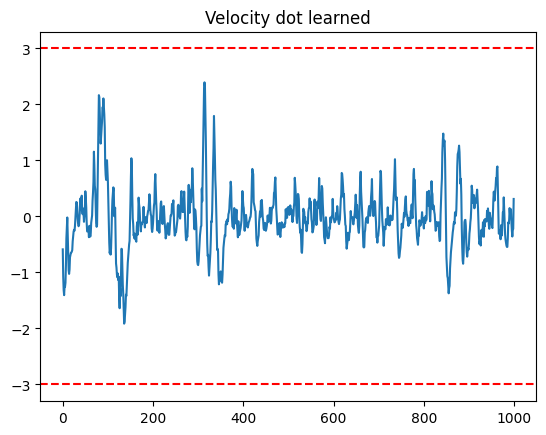

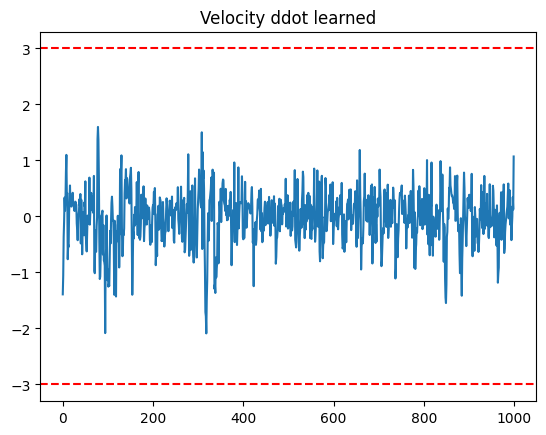

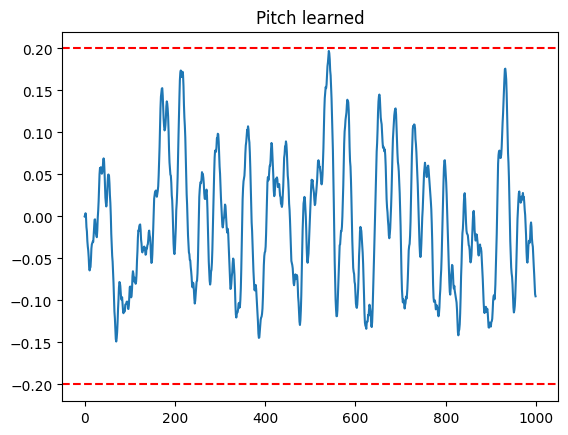

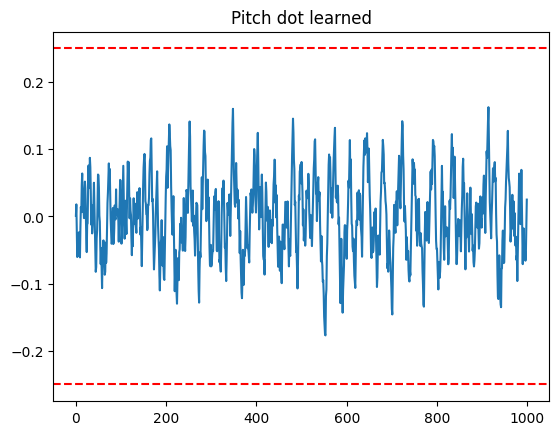

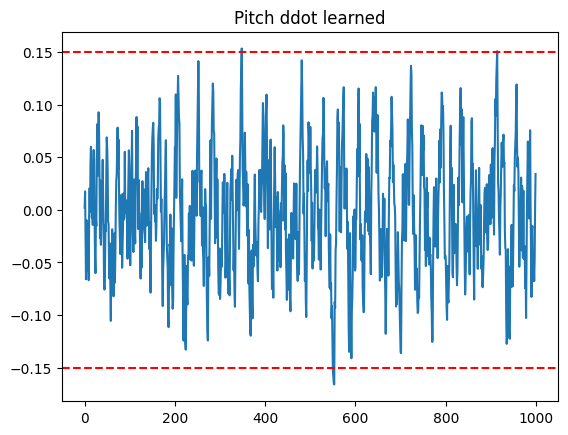

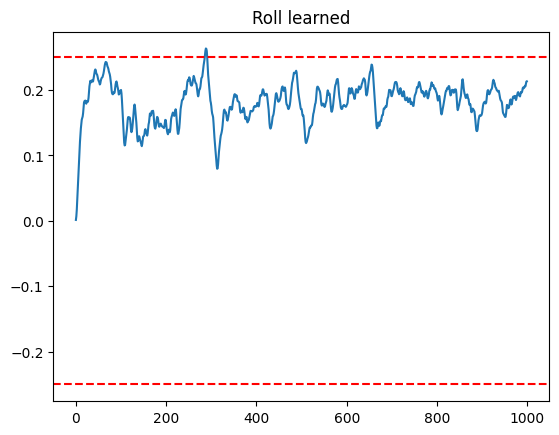

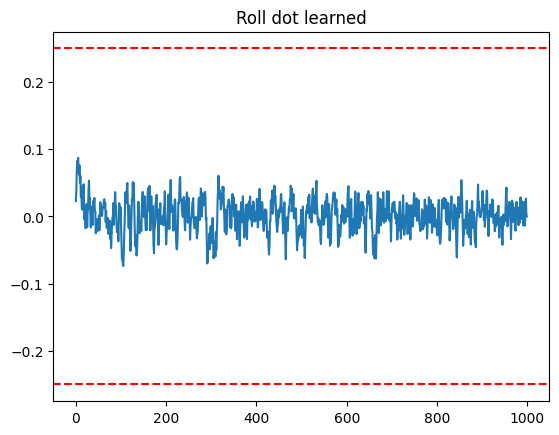

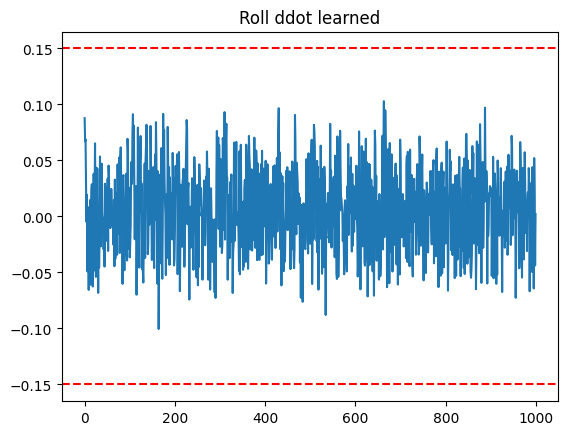

In [21]:
plt.figure()
plt.plot(controls_learned[:,:,0].T)
plt.axhline(y=v_max, color='red', linestyle='--')
plt.axhline(y=v_min, color='red', linestyle='--')
plt.title('Velocity learned')
plt.show()

plt.figure()
plt.plot(controls_dot_learned[:,:,0].T)
plt.axhline(y=vdot_max, color='red', linestyle='--')
plt.axhline(y=vdot_min, color='red', linestyle='--')
plt.title('Velocity dot learned')
plt.show()

plt.figure()
plt.plot(controls_ddot_learned[:,:,0].T)
plt.axhline(y=vddot_max, color='red', linestyle='--')
plt.axhline(y=vddot_min, color='red', linestyle='--')
plt.title('Velocity ddot learned')
plt.show()

plt.figure()
plt.plot(controls_learned[:,:,1].T)
plt.axhline(y=pitch_max, color='red', linestyle='--')
plt.axhline(y=pitch_min, color='red', linestyle='--')
plt.title('Pitch learned')
plt.show()

plt.figure()
plt.plot(controls_dot_learned[:,:,1].T)
plt.axhline(y=pitchdot_max, color='red', linestyle='--')
plt.axhline(y=pitchdot_min, color='red', linestyle='--')
plt.title('Pitch dot learned')
plt.show()

plt.figure()
plt.plot(controls_ddot_learned[:,:,1].T)
plt.axhline(y=pitchddot_max, color='red', linestyle='--')
plt.axhline(y=pitchddot_min, color='red', linestyle='--')
plt.title('Pitch ddot learned')
plt.show()  

plt.figure()
plt.plot(controls_learned[:,:,2].T)
plt.axhline(y=roll_max, color='red', linestyle='--')
plt.axhline(y=roll_min, color='red', linestyle='--')
plt.title('Roll learned')
plt.show()

plt.figure()
plt.plot(controls_dot_learned[:,:,2].T)
plt.axhline(y=rolldot_max, color='red', linestyle='--')
plt.axhline(y=rolldot_min, color='red', linestyle='--')
plt.title('Roll dot learned')
plt.show()

plt.figure()
plt.plot(controls_ddot_learned[:,:,2].T)
plt.axhline(y=rollddot_max, color='red', linestyle='--')
plt.axhline(y=rollddot_min, color='red', linestyle='--')
plt.title('Roll ddot learned')
plt.show()

In [22]:
# plt.figure(12)
# plt.plot(opt_traj[:,:,0].T,opt_traj[:,:,1].T)
# plt.title('Optimal trajectory rollout')
# plt.show()



In [23]:
min_distance_goal_proj = np.zeros(num_case)
mean_distance_goal_proj = np.zeros(num_case)
for i in range(num_case):
    dist_goal_proj = np.sqrt((states_proj_global[i,:,0] - goal_location[i,0])**2+(states_proj_global[i,:,1]-goal_location[i,1])**2+
    (states_proj_global[i,:,2]-goal_location[i,2])**2)
    min_distance_goal_proj[i] = np.min(dist_goal_proj)
    mean_distance_goal_proj[i] = np.mean(dist_goal_proj)
mean_min_dist_goal_proj = np.mean(min_distance_goal_proj)
mean_mean_dist_goal_proj = np.mean(mean_distance_goal_proj)
print("mean_min_dist_goal_proj",mean_min_dist_goal_proj)
print("mean_mean_dist_goal_proj",mean_mean_dist_goal_proj)

min_distance_goal_learned = np.zeros(num_case)
mean_distance_goal_learned = np.zeros(num_case)
for i in range(num_case):
    dist_goal_learned = np.sqrt((states_learned_global[i,:,0] - goal_location[i,0])**2+(states_learned_global[i,:,1]-goal_location[i,1])**2+
    (states_learned_global[i,:,2]-goal_location[i,2])**2)
    min_distance_goal_learned[i] = np.min(dist_goal_learned)
    mean_distance_goal_learned[i] = np.mean(dist_goal_learned)
mean_min_dist_goal_learned = np.mean(min_distance_goal_learned)
mean_mean_dist_goal_learned = np.mean(mean_distance_goal_learned)
print("mean_min_dist_goal_learned",mean_min_dist_goal_learned)
print("mean_mean_dist_goal_learned",mean_mean_dist_goal_learned)

mean_min_dist_goal_proj 54.30578349301272
mean_mean_dist_goal_proj 99.90442268551656
mean_min_dist_goal_learned 85.54461921585352
mean_mean_dist_goal_learned 127.6919123029181


In [24]:
con_viol_vel_proj = np.zeros(num_case)
sum_con_viol_vel_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_proj = np.zeros(timesteps)
    for j in range(timesteps):
        if controls_proj[i,j,0]>v_max:
            conviol_vel_proj[j] = (controls_proj[i,j,0]-v_max)
        elif controls_proj[i,j,0]<v_min:
            conviol_vel_proj[j] = (v_min-controls_proj[i,j,0])
        else:pass
    con_viol_vel_proj[i] = np.mean(conviol_vel_proj)
    sum_con_viol_vel_proj[i] = np.sum(conviol_vel_proj)
mean_con_viol_vel_proj = np.mean(con_viol_vel_proj)
tot_con_viol_vel_proj = np.sum(sum_con_viol_vel_proj)
print("\nmean_con_viol_vel_proj",mean_con_viol_vel_proj)
print("tot_con_viol_vel_proj",tot_con_viol_vel_proj)

con_viol_vel_dot_proj = np.zeros(num_case)
sum_con_viol_vel_dot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_dot_proj = np.maximum(0,(np.abs(controls_dot_proj[i,:,0])-vdot_max))
    con_viol_vel_dot_proj[i] = np.mean(conviol_vel_dot_proj)
    sum_con_viol_vel_dot_proj[i] = np.sum(conviol_vel_dot_proj)
mean_con_viol_vel_dot_proj = np.mean(con_viol_vel_dot_proj)
tot_con_viol_vel_dot_proj = np.sum(sum_con_viol_vel_dot_proj)
print("mean_con_viol_vel_dot_proj",mean_con_viol_vel_dot_proj)
print("tot_con_viol_vel_dot_proj",tot_con_viol_vel_dot_proj)

con_viol_vel_ddot_proj = np.zeros(num_case)
sum_con_viol_vel_ddot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_ddot_proj = np.maximum(0,(np.abs(controls_ddot_proj[i,:,0])-vddot_max))
    con_viol_vel_ddot_proj[i] = np.mean(conviol_vel_ddot_proj)
    sum_con_viol_vel_ddot_proj[i] = np.sum(conviol_vel_ddot_proj)
mean_con_viol_vel_ddot_proj = np.mean(con_viol_vel_ddot_proj)
tot_con_viol_vel_ddot_proj = np.sum(sum_con_viol_vel_ddot_proj)
print("mean_con_viol_vel_ddot_proj",mean_con_viol_vel_ddot_proj)
print("tot_con_viol_vel_ddot_proj",tot_con_viol_vel_ddot_proj)

con_viol_pitch_proj = np.zeros(num_case)
sum_con_viol_pitch_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_proj = np.maximum(0,(np.abs(controls_proj[i,:,1])-pitch_max))
    con_viol_pitch_proj[i] = np.mean(conviol_pitch_proj)
    sum_con_viol_pitch_proj[i] = np.sum(conviol_pitch_proj)
mean_con_viol_pitch_proj = np.mean(con_viol_pitch_proj)
tot_con_viol_pitch_proj = np.sum(sum_con_viol_pitch_proj)
print("mean_con_viol_pitch_proj",mean_con_viol_pitch_proj)
print("tot_con_viol_pitch_proj",tot_con_viol_pitch_proj)

con_viol_pitch_dot_proj = np.zeros(num_case)
sum_con_viol_pitch_dot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_dot_proj = np.maximum(0,(np.abs(controls_dot_proj[i,:,1])-pitchdot_max))
    con_viol_pitch_dot_proj[i] = np.mean(conviol_pitch_dot_proj)
    sum_con_viol_pitch_dot_proj[i] = np.sum(conviol_pitch_dot_proj)
mean_con_viol_pitch_dot_proj = np.mean(con_viol_pitch_dot_proj)
tot_con_viol_pitch_dot_proj = np.sum(sum_con_viol_pitch_dot_proj)
print("mean_con_viol_pitch_dot_proj",mean_con_viol_pitch_dot_proj)
print("tot_con_viol_pitch_dot_proj",tot_con_viol_pitch_dot_proj)

con_viol_pitch_ddot_proj = np.zeros(num_case)
sum_con_viol_pitch_ddot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_ddot_proj = np.maximum(0,(np.abs(controls_ddot_proj[i,:,1])-pitchddot_max))
    con_viol_pitch_ddot_proj[i] = np.mean(conviol_pitch_ddot_proj)
    sum_con_viol_pitch_ddot_proj[i] = np.sum(conviol_pitch_ddot_proj)
mean_con_viol_pitch_ddot_proj = np.mean(con_viol_pitch_ddot_proj)
tot_con_viol_pitch_ddot_proj = np.sum(sum_con_viol_pitch_ddot_proj)
print("mean_con_viol_pitch_ddot_proj",mean_con_viol_pitch_ddot_proj)
print("tot_con_viol_pitch_ddot_proj",tot_con_viol_pitch_ddot_proj)


con_viol_roll_proj = np.zeros(num_case)
sum_con_viol_roll_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_proj = np.maximum(0,(np.abs(controls_proj[i,:,2])-roll_max))
    con_viol_roll_proj[i] = np.mean(conviol_roll_proj)
    sum_con_viol_roll_proj[i] = np.sum(conviol_roll_proj)
mean_con_viol_roll_proj = np.mean(con_viol_roll_proj)
tot_con_viol_roll_proj = np.sum(sum_con_viol_roll_proj)
print("mean_con_viol_roll_proj",mean_con_viol_roll_proj)
print("tot_con_viol_roll_proj",tot_con_viol_roll_proj)

con_viol_roll_dot_proj = np.zeros(num_case)
sum_con_viol_roll_dot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_dot_proj = np.maximum(0,(np.abs(controls_dot_proj[i,:,2])-rolldot_max))
    con_viol_roll_dot_proj[i] = np.mean(conviol_roll_dot_proj)
    sum_con_viol_roll_dot_proj[i] = np.sum(conviol_roll_dot_proj)
mean_con_viol_roll_dot_proj = np.mean(con_viol_roll_dot_proj)
tot_con_viol_roll_dot_proj = np.sum(sum_con_viol_roll_dot_proj)
print("mean_con_viol_roll_dot_proj",mean_con_viol_roll_dot_proj)
print("tot_con_viol_roll_dot_proj",tot_con_viol_roll_dot_proj)

con_viol_roll_ddot_proj = np.zeros(num_case)
sum_con_viol_roll_ddot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_ddot_proj = np.maximum(0,(np.abs(controls_ddot_proj[i,:,2])-rollddot_max))
    con_viol_roll_ddot_proj[i] = np.mean(conviol_roll_ddot_proj)
    sum_con_viol_roll_ddot_proj[i] = np.sum(conviol_roll_ddot_proj)
mean_con_viol_roll_ddot_proj = np.mean(con_viol_roll_ddot_proj)
tot_con_viol_roll_ddot_proj = np.sum(sum_con_viol_roll_ddot_proj)
print("mean_con_viol_roll_ddot_proj",mean_con_viol_roll_ddot_proj)
print("tot_con_viol_roll_ddot_proj",tot_con_viol_roll_ddot_proj)




con_viol_vel_learned = np.zeros(num_case)
sum_con_viol_vel_learned = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_learned = np.zeros(timesteps)
    for j in range(timesteps):
        if controls_learned[i,j,0]>v_max:
            conviol_vel_learned[j] = (controls_learned[i,j,0]-v_max)
        elif controls_learned[i,j,0]<v_min:
            conviol_vel_learned[j] = (v_min-controls_learned[i,j,0])
        else:pass
    con_viol_vel_learned[i] = np.mean(conviol_vel_learned)
    sum_con_viol_vel_learned[i] = np.sum(conviol_vel_learned)
mean_con_viol_vel_learned = np.mean(con_viol_vel_learned)
tot_con_viol_vel_learned = np.sum(sum_con_viol_vel_learned)
print("\nmean_con_viol_vel_learned",mean_con_viol_vel_learned)
print("tot_con_viol_vel_learned",tot_con_viol_vel_learned)

con_viol_vel_dot_learned = np.zeros(num_case)
sum_con_viol_vel_dot_learned = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_dot_learned = np.maximum(0,(np.abs(controls_dot_learned[i,:,0])-vdot_max))
    con_viol_vel_dot_learned[i] = np.mean(conviol_vel_dot_learned)
    sum_con_viol_vel_dot_learned[i] = np.sum(conviol_vel_dot_learned)
mean_con_viol_vel_dot_learned = np.mean(con_viol_vel_dot_learned)
tot_con_viol_vel_dot_learned = np.sum(sum_con_viol_vel_dot_learned)
print("mean_con_viol_vel_dot_learned",mean_con_viol_vel_dot_learned)
print("tot_con_viol_vel_dot_learned",tot_con_viol_vel_dot_learned)

con_viol_vel_ddot_learned = np.zeros(num_case)
sum_con_viol_vel_ddot_learned = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_ddot_learned = np.maximum(0,(np.abs(controls_ddot_learned[i,:,0])-vddot_max))
    con_viol_vel_ddot_learned[i] = np.mean(conviol_vel_ddot_learned)
    sum_con_viol_vel_ddot_learned[i] = np.sum(conviol_vel_ddot_learned)
mean_con_viol_vel_ddot_learned = np.mean(con_viol_vel_ddot_learned)
tot_con_viol_vel_ddot_learned = np.sum(sum_con_viol_vel_ddot_learned)
print("mean_con_viol_vel_ddot_learned",mean_con_viol_vel_ddot_learned)
print("tot_con_viol_vel_ddot_learned",tot_con_viol_vel_ddot_learned)

con_viol_pitch_learned = np.zeros(num_case)
sum_con_viol_pitch_learned = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_learned = np.maximum(0,(np.abs(controls_learned[i,:,1])-pitch_max))
    con_viol_pitch_learned[i] = np.mean(conviol_pitch_learned)
    sum_con_viol_pitch_learned[i] = np.sum(conviol_pitch_learned)
mean_con_viol_pitch_learned = np.mean(con_viol_pitch_learned)
tot_con_viol_pitch_learned = np.sum(sum_con_viol_pitch_learned)
print("mean_con_viol_pitch_learned",mean_con_viol_pitch_learned)
print("tot_con_viol_pitch_learned",tot_con_viol_pitch_learned)

con_viol_pitch_dot_learned = np.zeros(num_case)
sum_con_viol_pitch_dot_learned = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_dot_learned = np.maximum(0,(np.abs(controls_dot_learned[i,:,1])-pitchdot_max))
    con_viol_pitch_dot_learned[i] = np.mean(conviol_pitch_dot_learned)
    sum_con_viol_pitch_dot_learned[i] = np.sum(conviol_pitch_dot_learned)
mean_con_viol_pitch_dot_learned = np.mean(con_viol_pitch_dot_learned)
tot_con_viol_pitch_dot_learned = np.sum(sum_con_viol_pitch_dot_learned)
print("mean_con_viol_pitch_dot_learned",mean_con_viol_pitch_dot_learned)
print("tot_con_viol_pitch_dot_learned",tot_con_viol_pitch_dot_learned)

con_viol_pitch_ddot_learned = np.zeros(num_case)
sum_con_viol_pitch_ddot_learned = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_ddot_learned = np.maximum(0,(np.abs(controls_ddot_learned[i,:,1])-pitchddot_max))
    con_viol_pitch_ddot_learned[i] = np.mean(conviol_pitch_ddot_learned)
    sum_con_viol_pitch_ddot_learned[i] = np.sum(conviol_pitch_ddot_learned)
mean_con_viol_pitch_ddot_learned = np.mean(con_viol_pitch_ddot_learned)
tot_con_viol_pitch_ddot_learned = np.sum(sum_con_viol_pitch_ddot_learned)
print("mean_con_viol_pitch_ddot_learned",mean_con_viol_pitch_ddot_learned)
print("tot_con_viol_pitch_ddot_learned",tot_con_viol_pitch_ddot_learned)


con_viol_roll_learned = np.zeros(num_case)
sum_con_viol_roll_learned = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_learned = np.maximum(0,(np.abs(controls_learned[i,:,2])-roll_max))
    con_viol_roll_learned[i] = np.mean(conviol_roll_learned)
    sum_con_viol_roll_learned[i] = np.sum(conviol_roll_learned)
mean_con_viol_roll_learned = np.mean(con_viol_roll_learned)
tot_con_viol_roll_learned = np.sum(sum_con_viol_roll_learned)
print("mean_con_viol_roll_learned",mean_con_viol_roll_learned)
print("tot_con_viol_roll_learned",tot_con_viol_roll_learned)

con_viol_roll_dot_learned = np.zeros(num_case)
sum_con_viol_roll_dot_learned = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_dot_learned = np.maximum(0,(np.abs(controls_dot_learned[i,:,2])-rolldot_max))
    con_viol_roll_dot_learned[i] = np.mean(conviol_roll_dot_learned)
    sum_con_viol_roll_dot_learned[i] = np.sum(conviol_roll_dot_learned)
mean_con_viol_roll_dot_learned = np.mean(con_viol_roll_dot_learned)
tot_con_viol_roll_dot_learned = np.sum(sum_con_viol_roll_dot_learned)
print("mean_con_viol_roll_dot_learned",mean_con_viol_roll_dot_learned)
print("tot_con_viol_roll_dot_learned",tot_con_viol_roll_dot_learned)

con_viol_roll_ddot_learned = np.zeros(num_case)
sum_con_viol_roll_ddot_learned = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_ddot_learned = np.maximum(0,(np.abs(controls_ddot_learned[i,:,2])-rollddot_max))
    con_viol_roll_ddot_learned[i] = np.mean(conviol_roll_ddot_learned)
    sum_con_viol_roll_ddot_learned[i] = np.sum(conviol_roll_ddot_learned)
mean_con_viol_roll_ddot_learned = np.mean(con_viol_roll_ddot_learned)
tot_con_viol_roll_ddot_learned = np.sum(sum_con_viol_roll_ddot_learned)
print("mean_con_viol_roll_ddot_learned",mean_con_viol_roll_ddot_learned)
print("tot_con_viol_roll_ddot_learned",tot_con_viol_roll_ddot_learned)


mean_con_viol_vel_proj 0.00015052986145019532
tot_con_viol_vel_proj 0.1505298614501953
mean_con_viol_vel_dot_proj 0.0
tot_con_viol_vel_dot_proj 0.0
mean_con_viol_vel_ddot_proj 0.0
tot_con_viol_vel_ddot_proj 0.0
mean_con_viol_pitch_proj 7.332199811935408e-05
tot_con_viol_pitch_proj 0.07332199811935408
mean_con_viol_pitch_dot_proj 0.0
tot_con_viol_pitch_dot_proj 0.0
mean_con_viol_pitch_ddot_proj 7.377823591232305e-05
tot_con_viol_pitch_ddot_proj 0.07377823591232305
mean_con_viol_roll_proj 0.0
tot_con_viol_roll_proj 0.0
mean_con_viol_roll_dot_proj 0.0
tot_con_viol_roll_dot_proj 0.0
mean_con_viol_roll_ddot_proj 0.0
tot_con_viol_roll_ddot_proj 0.0

mean_con_viol_vel_learned 6.75954818725586e-05
tot_con_viol_vel_learned 0.0675954818725586
mean_con_viol_vel_dot_learned 0.0
tot_con_viol_vel_dot_learned 0.0
mean_con_viol_vel_ddot_learned 0.0
tot_con_viol_vel_ddot_learned 0.0
mean_con_viol_pitch_learned 0.0
tot_con_viol_pitch_learned 0.0
mean_con_viol_pitch_dot_learned 0.0
tot_con_viol_pitch_do

In [25]:
# np.savez('./mppi/data/obs_comparison_result_learned_vs_proj_50iter',goal_location=goal_location,obs_x_batch=obs_x_batch,obs_y_batch=obs_y_batch,
# obs_z_batch=obs_z_batch,obs_r_batch=obs_r_batch,
# controls_proj=controls_proj,dot_proj=controls_dot_proj,ddot_proj=controls_ddot_proj,obs_dist_proj=obs_dist_proj,states_proj_global=states_proj_global,success_proj_overall=success_proj_overall,
# fail_proj_cases=fail_proj_cases,min_distance_goal_proj=min_distance_goal_proj,mean_min_dist_goal_proj=mean_min_dist_goal_proj,con_viol_vel_proj=con_viol_vel_proj,con_viol_vel_dot_proj=con_viol_vel_dot_proj,
# con_viol_vel_ddot_proj=con_viol_vel_ddot_proj,con_viol_pitch_proj=con_viol_pitch_proj,con_viol_pitch_dot_proj=con_viol_pitch_dot_proj,con_viol_pitch_ddot_proj=con_viol_pitch_ddot_proj,
# con_viol_roll_proj=con_viol_roll_proj,con_viol_roll_dot_proj=con_viol_roll_dot_proj,con_viol_roll_ddot_proj=con_viol_roll_ddot_proj,mean_con_viol_vel_proj=mean_con_viol_vel_proj,
# mean_con_viol_vel_dot_proj=mean_con_viol_vel_dot_proj,mean_con_viol_vel_ddot_proj=mean_con_viol_vel_ddot_proj,mean_con_viol_pitch_proj=mean_con_viol_pitch_proj,
# mean_con_viol_pitch_dot_proj=mean_con_viol_pitch_dot_proj,mean_con_viol_pitch_ddot_proj=mean_con_viol_pitch_ddot_proj,mean_con_viol_roll_proj=mean_con_viol_roll_proj,
# mean_con_viol_roll_dot_proj=mean_con_viol_roll_dot_proj,mean_con_viol_roll_ddot_proj=mean_con_viol_roll_ddot_proj,states_train=states_train,
# mean_proj_values=mean_proj_values,mean_mean_dist_goal_proj=mean_mean_dist_goal_proj,tot_con_viol_vel_proj=tot_con_viol_vel_proj,
# tot_con_viol_vel_dot_proj=tot_con_viol_vel_dot_proj,tot_con_viol_vel_ddot_proj=tot_con_viol_vel_ddot_proj,tot_con_viol_pitch_proj=tot_con_viol_pitch_proj,
# tot_con_viol_pitch_dot_proj=tot_con_viol_pitch_dot_proj,tot_con_viol_pitch_ddot_proj=tot_con_viol_pitch_ddot_proj,tot_con_viol_roll_proj=tot_con_viol_roll_proj,
# tot_con_viol_roll_dot_proj=tot_con_viol_roll_dot_proj,tot_con_viol_roll_ddot_proj=tot_con_viol_roll_ddot_proj,
# controls_learned=controls_learned,dot_learned=controls_dot_learned,ddot_learned=controls_ddot_learned,obs_dist_learned=obs_dist_learned,states_learned_global=states_learned_global,success_learned_overall=success_learned_overall,
# fail_learned_cases=fail_learned_cases,min_distance_goal_learned=min_distance_goal_learned,mean_min_dist_goal_learned=mean_min_dist_goal_learned,con_viol_vel_learned=con_viol_vel_learned,con_viol_vel_dot_learned=con_viol_vel_dot_learned,
# con_viol_vel_ddot_learned=con_viol_vel_ddot_learned,con_viol_pitch_learned=con_viol_pitch_learned,con_viol_pitch_dot_learned=con_viol_pitch_dot_learned,con_viol_pitch_ddot_learned=con_viol_pitch_ddot_learned,
# con_viol_roll_learned=con_viol_roll_learned,con_viol_roll_dot_learned=con_viol_roll_dot_learned,con_viol_roll_ddot_learned=con_viol_roll_ddot_learned,mean_con_viol_vel_learned=mean_con_viol_vel_learned,
# mean_con_viol_vel_dot_learned=mean_con_viol_vel_dot_learned,mean_con_viol_vel_ddot_learned=mean_con_viol_vel_ddot_learned,mean_con_viol_pitch_learned=mean_con_viol_pitch_learned,
# mean_con_viol_pitch_dot_learned=mean_con_viol_pitch_dot_learned,mean_con_viol_pitch_ddot_learned=mean_con_viol_pitch_ddot_learned,mean_con_viol_roll_learned=mean_con_viol_roll_learned,
# mean_con_viol_roll_dot_learned=mean_con_viol_roll_dot_learned,mean_con_viol_roll_ddot_learned=mean_con_viol_roll_ddot_learned,states_train_learned=states_train_learned,
# mean_learned_values=mean_learned_values,mean_mean_dist_goal_learned=mean_mean_dist_goal_learned,tot_con_viol_vel_learned=tot_con_viol_vel_learned,
# tot_con_viol_vel_dot_learned=tot_con_viol_vel_dot_learned,tot_con_viol_vel_ddot_learned=tot_con_viol_vel_ddot_learned,tot_con_viol_pitch_learned=tot_con_viol_pitch_learned,
# tot_con_viol_pitch_dot_learned=tot_con_viol_pitch_dot_learned,tot_con_viol_pitch_ddot_learned=tot_con_viol_pitch_ddot_learned,tot_con_viol_roll_learned=tot_con_viol_roll_learned,
# tot_con_viol_roll_dot_learned=tot_con_viol_roll_dot_learned,tot_con_viol_roll_ddot_learned=tot_con_viol_roll_ddot_learned)

In [26]:
# np.savez('./mppi/data/c_samples/c_samples_obs_n250',raw_sample_values=raw_sample_values,proj_sample_values=proj_sample_values)